# Predicting Premier League match results based on historic data

#  1 Introduction & Project Overview

In recent years, bookmakers have made use of a multiple sophisticated strategies in order
to set odds at a level where the least exposure to risk (hence the most chance of steady
profit) and the maximum attractiveness to clients. These strategies use massive amounts of
collected data, often live feeds for in-play odds, with a host of machine learning algorithms
to calculate the odds. Clients involved in betting are often layman to the underlying mathematical complexities of the odds and often have no means of accurately judging the likihoods
of outcomes.


The most popular and developed sport in the world is Football, and arguably the English
Premier league is the most competitive, and it is therefore the most natural choice to study.
The game of football is constantly evolving, and features that may be important in one
generation may become less so later - there has never been an analytic definition of the
game. This is where machine learning could prove invaluable.


In this project, we look at applying statistical and machine learning methods, in order to attempt at predicting match results based on historic data of the teams that play the match. A majority part of the project builds a framework that takes raw match data and creates suitable features based on historic statistics to match results. We then by using Decision trees and Random forest classifiers and finally we build deep learning logic, combine it with a number of feature selection tools, including PCA, to get the best accuracy metric.

## Problem Statement

The premise then lies, to build a machine learning framework, that can use historic data
from football matches between two teams and learn how to best predict outcomes of games.
The general outline of the steps to be taken to get to a framework that can get to the premise are as follows:
- Recover a source of data with enough information that links team performance to final result.
- Build a tool which takes the raw data and transforms it into a format in which each match has a number of historic features based on previous games, such as 'Average goals in x games'.
- Use feature selection tools to filter out unimportant/redundant features.
- Feed features into a number of machine learning algorithms and decide on the best one to fine-tune.
- Fine-tune the chosen machine learning algorithm for the greatest accuracy.


## Background & Metrics

As previously stated, the use of machine learning in the gambling industry has grown in recent past. Along with this steady academic interest has also shot up as well with many academic journals and papers detailing the methodology and results gathered. One such study (PETTERSSON,NYQUIST,2017)[1] used recurrent neural networks to predict the outcome of games with in-game infomration as the game progressed; the study used an accuracy metric, which ranged from 33.5% to 98% as the game progressed. Another study (HERBINET, 2018)[2] used publically available databases along with classical machine learning algorithms (regression, svm etc) to predict match outcomes and expected goals using aggregated statistics and player ratings. The study managed to accurate predict outcome of matches 50% of time.

In this project, we will employ the use of the accuracy metric, which simply calculates the percentage of correct predictions vs total predictions of the test data:

$$Accuracy=\frac{\sum{N_{C}}}{\sum{N_{total}}}$$

Where $N_{C} =1$ for a correct prediction, and $N_{total}$ is the total number of predictions.


# 2 Data Preprocessing & Exploration

We sourced premier league match results from football-data.co.uk, the website has downloadable csv files for each season of the premier league from 1993 [3]. We used data from season 2000-2001 onwards as this data had the most consistancy  in features throughout. 

On first inspection, we see a number of features. These features describe the events that occur in the game, such as total goals by the home side (FTHG). The list below describes what each of these mean. 

```
Div = League Division
Date = Match Date (dd/mm/yy)
HomeTeam = Home Team
AwayTeam = Away Team
FTHG and HG = Full Time Home Team Goals
FTAG and AG = Full Time Away Team Goals
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
HTHG = Half Time Home Team Goals
HTAG = Half Time Away Team Goals
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)
HS = Home Team Shots
AS = Away Team Shots
HST = Home Team Shots on Target
AST = Away Team Shots on Target
HHW = Home Team Hit Woodwork
AHW = Away Team Hit Woodwork
HC = Home Team Corners
AC = Away Team Corners
HF = Home Team Fouls Committed
AF = Away Team Fouls Committed
HFKC = Home Team Free Kicks Conceded
AFKC = Away Team Free Kicks Conceded
HO = Home Team Offsides
AO = Away Team Offsides
HY = Home Team Yellow Cards
AY = Away Team Yellow Cards
HR = Home Team Red Cards

```




In [20]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import copy
os.chdir("capstone_proj/csv_files")
""" In this section, we will take an in-depth view of the dataset. We will see
what we have available and whether we can make some initial predictions"""
s0001 = pd.read_csv("2000_2001.csv")
colsToKeep = list(["Div","Date","HomeTeam","AwayTeam","FTHG","HG","FTAG","AG","FTR","Res","HTHG","HTAG","HTR","HS","AS","HST","AST","HHW","AHW","HC","AC","HF","AF","HO","AO","HY","AY","HR","AR"])
allCols = s0001.columns
colsToDrop = set(allCols) - set(colsToKeep)
s0001 = s0001.drop(labels=colsToDrop,axis=1)
### Data ###
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(s0001.head())


  Div      Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  HS  \
0  E0  19/08/00  Charlton       Man City     4     0   H     2     0   H  17   
1  E0  19/08/00   Chelsea       West Ham     4     2   H     1     0   H  17   
2  E0  19/08/00  Coventry  Middlesbrough     1     3   A     1     1   D   6   
3  E0  19/08/00     Derby    Southampton     2     2   D     1     2   A   6   
4  E0  19/08/00     Leeds        Everton     2     0   H     2     0   H  17   

   AS  HST  AST  HHW  AHW  HC  AC  HF  AF  HO  AO  HY  AY  HR  AR  
0   8   14    4    2    1   6   6  13  12   8   6   1   2   0   0  
1  12   10    5    1    0   7   7  19  14   2   3   1   2   0   0  
2  16    3    9    0    1   8   4  15  21   1   3   5   3   1   0  
3  13    4    6    0    0   5   8  11  13   0   2   1   1   0   0  
4  12    8    6    0    0   6   4  21  20   6   1   1   3   0   0  


We constructed basic statistics on the data, the table below shows this in detail. 

In [24]:
describe = (s0001.describe())

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print((s0001.describe()))



             FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000   
mean     1.544737    1.065789    0.686842    0.476316   12.792105    9.378947   
std      1.285436    1.029070    0.843623    0.694469    4.859117    3.609366   
min      0.000000    0.000000    0.000000    0.000000    0.000000    2.000000   
25%      1.000000    0.000000    0.000000    0.000000    9.000000    7.000000   
50%      1.000000    1.000000    0.000000    0.000000   12.000000    9.000000   
75%      2.000000    2.000000    1.000000    1.000000   16.000000   12.000000   
max      6.000000    4.000000    5.000000    4.000000   33.000000   24.000000   

              HST         AST         HHW         AHW          HC          AC  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000   
mean     6.163158    4.531579    0.381579    0.223684    6.289474    4.647368   
std      2.991582    2.2393

What we see is that there are 380 games in total in a season. Other interesting things to note are the difference between away and home games, from first glance it shows favourable statistics are higher for home games. In the below plot, we see that home side values are higher in features that are associated with wins such as 'Shots on Target' and lower in features that associate with being under pressure, such as 'Fouls'. What this shows is that there is reason to consider home and away as a potential feature, and so we will seperate features based on this.

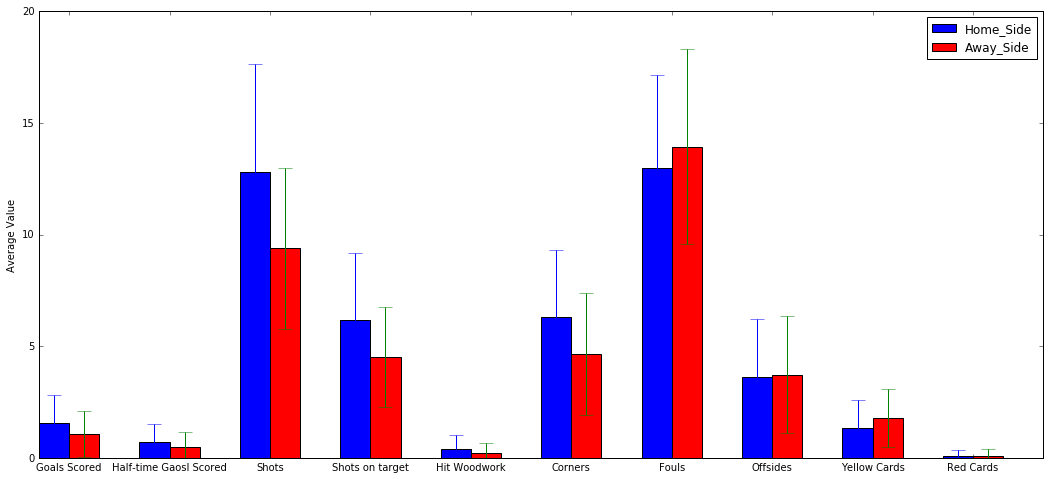

In [37]:
%matplotlib inline
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
pd.DataFrame.to_latex(s0001.describe())
# width of the bars
barWidth = 0.3
# Choose the height of the blue bars
bars1 = np.array(describe[1:2][(['FTHG','HTHG','HS','HST','HHW','HC','HF','HO','HY','HR'])]).flatten()
# Choose the height of the cyan bars
bars2 = np.array(describe[1:2][(['FTAG','HTAG','AS','AST','AHW','AC','AF','AO','AY','AR'])]).flatten()
# Choose the height of the error bars (bars1)
yer1 = np.array(describe[2:3][(['FTHG','HTHG','HS','HST','HHW','HC','HF','HO','HY','HR'])]).flatten()
# Choose the height of the error bars (bars2)
yer2 = np.array(describe[2:3][(['FTAG','HTAG','AS','AST','AHW','AC','AF','AO','AY','AR'])]).flatten()
# The x position of bars
r1 = np.arange(len(bars1.flatten()))
r2 = [x + barWidth for x in r1]
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Home_Side')
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'red', edgecolor = 'black', yerr=yer2, capsize=7, label='Away_Side')
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Goals Scored', 'Half-time Gaols Scored', 'Shots','Shots on target','Hit Woodwork', 'Corners','Fouls','Offsides','Yellow Cards','Red Cards','Booking points'])
plt.ylabel('Average Value')
plt.ylim(0)
plt.legend()
# Show graphic
plt.show()

The raw format of the data is not suitable to predict anything. We need to consider that features must be of historic values compared to targets and our framework must be flexible to allow us to select the number of games to lookback on. In this project we implement the following

1) A queryable database of: 
* games, keyed on season and the team.
* Season long statistics that will be used as fixed team attributes

2) A table of featrues and targets that is made by querying the built-up database, with build paremeters allowing one to choose lookback period.



### Building the database
We take the raw data format and load it into multiple Pandas' dataframe keyed by the season. 

In [44]:
def loadIntoDict(loc):
    df = pd.read_csv(loc,na_filter=True)
    colsToKeep = list(["Div","Date","HomeTeam","AwayTeam","FTHG","HG","FTAG","AG","FTR","Res","HTHG","HTAG","HTR","Attendance","Referee","HS","AS","HST","AST","HHW","AHW","HC","AC","HF","AF","HFKC","AFKC","HO","AO","HY","AY","HR","AR","HBP","ABP"])
    allCols = df.columns
    colsToDrop = set(allCols) - set(colsToKeep)
    return df.drop(labels=colsToDrop,axis=1)
## initialise dict
raw_season_data={}
## load in raw csvs
for i,j in enumerate(os.listdir()):
    raw_season_data[i]= loadIntoDict(j)
    
print("The following seasons have been loaded in raw format (in yy format) :")    
print(list(raw_season_data.keys()))

The following seasons have been loaded in raw format (in yy format) :
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


Next, we build the match 'snapshot' table. For each season, each team will have their matches, whether home or away recorded with the datapoints relating to those games available as a seasonal snapshot. We also record match results as a feature, and one-hot encode them into Win, Lose, Draw features. We see that we can query this database for each team and season via the command at the end: `snapshots[10]['Liverpool']`

In [54]:
## takes in rows of raw data and creates formatted dictionary based on whether the team was plaiyng at home or away

def create_home_dict(table,matchNum):
    matchDict={}
    if any('FTR' == table.keys()):
        matchDict={'result':table['FTR'].values[0]}
    elif any('Res'== table.keys()):
        matchDict = {'result':table['Res'].values[0]}
    if any('FTHG' == table.keys()):
        matchDict.update({'Goals':table['FTHG'].values[0]})
    elif any('HG'== table.keys()):
        matchDict.update({'Goals':table['HG'].values[0]})
    if any('FTAG' == table.keys()):
        matchDict.update({'GoalsConceded':table['FTAG'].values[0]})
    elif any('AG'== table.keys()):
        matchDict.update({'GoalsConceded':table['AG'].values[0]})
    matchDict.update({'match':matchNum,'ground':'H', \
                        'Date':table['Date'].values[0],\
                        'TeamAgainst':table['AwayTeam'].values[0],\
                        'HTGoals':table['HTHG'].values[0], \
                        'HTResult':table['HTR'].values[0], \
                        #'Attendance':table['Attendance'].values[0], \
                        'Shots':table['HS'].values[0],\
                        'ShotsAgainst':table['AS'].values[0],\
                        'ShotsOnTarget':table['HST'].values[0],\
                        'ShotsAgainstOnTarget':table['AST'].values[0],\
                        #'ShotsWoodwork':table['HHW'].values[0],\
                        #'ShotsAgainstWoodwork':table['AHW'].values[0],\
                        'Corners':table['HC'].values[0],\
                        'CornersAgainst':table['AC'].values[0],\
                        'FoulsCommited':table['HF'].values[0],\
                        'FoulsAgainst':table['AF'].values[0],\
                        #'Offsies':table['HO'].values[0],\
                        #'OffsidesAgainst':table['AO'].values[0],\
                        'YCards':table['HY'].values[0],\
                        'YCardsAgainst':table['AY'].values[0],\
                        'RCards':table['HR'].values[0],\
                        'RCardsAgainst':table['AR'].values[0]})
                        #'BookingPoints':table['HBP'].values[0],\
                        #'BookingPointsAgainst':table['ABP'].values[0]})

    matchDict.update({'BigChancesCreated': matchDict['ShotsOnTarget']+matchDict['Goals']})
    if matchDict['result']=='H':
        matchDict.update({'Win':1,'Draw':0, 'Lose':0})
    elif matchDict['result']=='A':
        matchDict.update({'Win':0,'Draw':0, 'Lose':1})
    else:
        matchDict.update({'Win':0,'Draw':1, 'Lose':0})
    return pd.DataFrame(matchDict,index=[matchNum,])


def create_away_dict(table,matchNum):
    matchDict={}
    if any('FTR' == table.keys()):
        matchDict={'result':table['FTR'].values[0]}
    elif any('Res'== table.keys()):
        matchDict = {'result':table['Res'].values[0]}
    if any('FTHG' == table.keys()):
        matchDict.update({'GoalsConceded':table['FTHG'].values[0]})
    elif any('HG'== table.keys()):
        matchDict.update({'GoalsConceded':table['HG'].values[0]})
    if any('FTAG' == table.keys()):
        matchDict.update({'Goals':table['FTAG'].values[0]})
    elif any('AG'== table.keys()):
        matchDict.update({'Goals':table['AG'].values[0]})
    matchDict.update({'match':matchNum,'ground':'A', \
                        'Date':table['Date'].values[0],\
                        'TeamAgainst':table['HomeTeam'].values[0],\
                        'HTGoals':table['HTAG'].values[0], \
                        'HTResult':table['HTR'].values[0], \
                        #'Attendance':table['Attendance'].values[0], \
                        'Shots':table['AS'].values[0],\
                        'ShotsAgainst':table['HS'].values[0],\
                        'ShotsOnTarget':table['AST'].values[0],\
                        'ShotsAgainstOnTarget':table['HST'].values[0],\
                        #'ShotsWoodwork':table['AHW'].values[0],\
                        #'ShotsAgainstWoodwork':table['HHW'].values[0],\
                        'Corners':table['AC'].values[0],\
                        'CornersAgainst':table['HC'].values[0],\
                        'FoulsCommited':table['AF'].values[0],\
                        'FoulsAgainst':table['HF'].values[0],\
                        #'Offsies':table['AO'].values[0],\
                        #'OffsidesAgainst':table['HO'].values[0],\
                        'YCards':table['AY'].values[0],\
                        'YCardsAgainst':table['HY'].values[0],\
                        'RCards':table['AR'].values[0],\
                        'RCardsAgainst':table['HR'].values[0]})
                        #'BookingPoints':table['ABP'].values[0],\
                        #'BookingPointsAgainst':table['HBP'].values[0]})
    matchDict.update({'BigChancesCreated': matchDict['ShotsOnTarget']+matchDict['Goals']})
    if matchDict['result']=='A':
        matchDict.update({'Win':1,'Draw':0, 'Lose':0})
    elif matchDict['result']=='H':
        matchDict.update({'Win':0,'Draw':0, 'Lose':1})
    else:
        matchDict.update({'Win':0,'Draw':1, 'Lose':0})
    return pd.DataFrame(matchDict,index=[matchNum,])

# The function below runs through each season, and each distinct team for that season and 
# uses the above functions to build the snapshot database

def build_snapshot_table(raw_data,snapshots):
    for i in raw_data.keys():
        snapshots[i]={}
        for j in list(set(raw_data[i]['AwayTeam'])):
            snapshots[i][j] = pd.DataFrame()
            tsTable=raw_data[i][(raw_data[i]['AwayTeam']==j) | (raw_data[i]['HomeTeam']==j)]
            for k in range(len(tsTable)):
                if j == tsTable.iloc[k]['AwayTeam']:
                    snapshots[i][j] = snapshots[i][j].append(create_away_dict(tsTable[k:k+1],k+1))
                elif j == tsTable.iloc[k]['HomeTeam']:
                    snapshots[i][j] = snapshots[i][j].append(create_home_dict(tsTable[k:k+1],k+1))
    return snapshots

snapshots={}
snapshots = build_snapshot_table(raw_season_data,snapshots)
print("the number of seasons built into the snapshots are:")
print(snapshots.keys())
print("In season of 2010, the following teams played:")
print(snapshots[10].keys())
print("Liverpools games looked like this:")
print((snapshots[10]['Liverpool']).head(3))


the number of seasons built into the snapshots are:
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
In season of 2010, the following teams played:
dict_keys(['Aston Villa', 'QPR', 'Newcastle', 'West Brom', 'Arsenal', 'Blackburn', 'Wolves', 'Chelsea', 'Man City', 'Everton', 'Wigan', 'Fulham', 'Liverpool', 'Swansea', 'Norwich', 'Stoke', 'Tottenham', 'Bolton', 'Man United', 'Sunderland'])
Liverpools games looked like this:
   BigChancesCreated  Corners  CornersAgainst      Date  Draw  FoulsAgainst  \
1                  5        6               3  13/08/11     1            12   
2                 10        5               9  20/08/11     0            11   
3                 12       12               6  27/08/11     0             7   

   FoulsCommited  Goals  GoalsConceded  HTGoals   ...   ShotsAgainst  \
1             17      1              1        1   ...             15   
2              6      2              0        0   ...             10   
3              5     

Using the database we created, we can build another queryable database featuring season-wide statistics, aggregated over the whole season - with such statistics like "Points" "Goal Difference" "Red Cards" etc.

This database is built for all games, all home games and all away games in a season - so that these statistics can be seperately queried.

In [55]:
# Take entire dataframe and build a single row of aggregations
def build_season_stats(teamDF,team):
    return {'Team': team,
    'Wins': sum(teamDF['Win']),
    'Losses': sum(teamDF['Lose']),
    'Draws': sum(teamDF['Draw']),
    'Goals': sum(teamDF['Goals']),
    'GoalsAgainst': sum(teamDF['GoalsConceded']),
    'YCards': sum(teamDF['YCards']),
    'RCards': sum(teamDF['RCards']),
    'avg_Goals':np.mean(teamDF['Goals']),
    'avg_GoalsAgainst':np.mean(teamDF['GoalsConceded']),
    'avg_Corners':np.mean(teamDF['Corners']),
    'avg_CornersAgaints':np.mean(teamDF['CornersAgainst']),
    'avg_Fouls':np.mean(teamDF['FoulsCommited']),
    'avg_FoulsAgainst':np.mean(teamDF['FoulsAgainst']),
    'avg_Shots':np.mean(teamDF['Shots']),
    'avg_ShotsAgainst':np.mean(teamDF['ShotsAgainst']),
    'avg_BigChancesCreated':np.mean(teamDF['BigChancesCreated']),
    }
## Take a season + team snapshot, query all,home and away games into smaller dataframes and feed them into build_season_stats,
## Add home and away prefix to show aggregations specific to the stadiums.
def build_team_summary(teamDF,team):
    homeDF = teamDF.query('ground == "H" ')
    awayDF = teamDF.query('ground == "A" ')
    seasonDict = build_season_stats(teamDF, team)
    homeDict = build_season_stats(homeDF,team)
    awayDict = build_season_stats(awayDF, team)
    homeDict = dict(zip(["home_" + i for i in homeDict.keys()],homeDict.values()))
    awayDict = dict(zip(["away_" + i for i in awayDict.keys()],awayDict.values()))
    seasonDict= {**seasonDict,**homeDict,**awayDict}
    seasonDict = {**seasonDict,**{'Points' : 3*seasonDict['Wins'] + (1 *seasonDict['Draws']), 'GD': seasonDict['Goals'] - seasonDict['GoalsAgainst']  }}

    return pd.DataFrame(seasonDict,index=[team,])

## Build entire database, take snapshots data and run through season+team data.
def build_season_table(snapshots):
    seasonTab = {}
    for i in snapshots.keys():
        seasonTab[i] = pd.DataFrame()
        for k in snapshots[i].keys():
            seasonTab[i] = seasonTab[i].append(build_team_summary(snapshots[i][k],k))
        seasonTab[i] = seasonTab[i].sort_values(by=['Points','GD'],ascending=False)
        seasonTab[i]['Position'] = np.linspace(1,20,20)
    return seasonTab

## build into seasonTable
seasonTable = build_season_table(snapshots)

print("The following seasons have been loaded")
print(seasonTable.keys())
print("This is what the 2010 season looked like")
print((seasonTable[10].sort_values(by=['Position'],ascending=True)).head())
print("These are the seasonal features available:")
print(seasonTable[10].keys())


The following seasons have been loaded
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
This is what the 2010 season looked like
            Draws  GD  Goals  GoalsAgainst  Losses  Points  RCards  \
Man City        5  64     93            29       5      89       5   
Man United      5  56     89            33       5      89       1   
Arsenal         7  25     74            49      10      70       4   
Tottenham       9  25     66            41       9      69       3   
Newcastle       8   5     56            51      11      65       2   

                  Team  Wins  YCards    ...     home_avg_BigChancesCreated  \
Man City      Man City    28      56    ...                      14.210526   
Man United  Man United    28      51    ...                      14.736842   
Arsenal        Arsenal    21      67    ...                      11.789474   
Tottenham    Tottenham    20      45    ...                      13.105263   
Newcastle    Newcastle    19      67   

With the databases made ready, we built the proper feature/target list by querying the databases. We considered a very large number of potential features. Features are broken down by the relevent data relating to the home sides historical statistics and the away sides. The below tables show this for the home side (HS). the exact same features were extracted for the away side (AS). 


|   Previous HS game   | Previous X HS games (5 by default) | Previous X HS-home games (5 by default) |  HS Previous Season Data  |   Previous Season Home Record  |   HS vs Away Team Record  |
|:--------------------:|:----------------------------------:|:---------------------------------------:|:-------------------------:|:------------------------------:|:-------------------------:|
|     Games Played     |          Average Rest Days         |        Average BigChancesCreated        |          Position         |           home Draws           |            Win            |
| Days since last game |      Average BigChancesCreated     |             Average Corners             |           Draws           |           home Goals           |            Draw           |
|   BigChancesCreated  |           Average Corners          |              Average points             |             GD            |        home GoalsAgainst       |            Loss           |
|        Corners       |           Average points           |              Average YCards             |           Goals           |           home Losses          |           Goals           |
|          Win         |           Average YCards           |              Average RCards             |        GoalsAgainst       |           home RCards          |       GoalsConceded       |
|         Draw         |           Average RCards           |              Average Goals              |           Losses          |            home Team           |     BigChancesCreated     |
|         Loss         |            Average Goals           |          Average GoalsConceded          |           Points          |            home Wins           | Average BigChancesCreated |
|         Goals        |        Average GoalsConceded       |                # of Wins                |           RCards          |           home YCards          |      Average Corners      |
|     GoalsConceded    |              # of Wins             |               # of Losses               |            Team           | home Average BigChancesCreated |       Average points      |
|     FoulsCommited    |             # of Losses            |                # of Draws               |            Wins           |      home Average Corners      |       Average YCards      |
|     FoulsAgainst     |             # of Draws             |               # of RCards               |           YCards          |   home Average CornersAgaints  |       Average RCards      |
|        RCards        |             # of RCards            |               # of YCards               | Average BigChancesCreated |       home Average Fouls       |       Average Goals       |
|     RCardsAgainst    |             # of YCards            |               # of YCards               |      Average Corners      |    home Average FoulsAgainst   |   Average GoalsConceded   |
|        YCards        |             # of YCards            |                                         |   Average CornersAgaints  |       home Average Goals       |                           |
|     YCardsAgainst    |                                    |                                         |       Average Fouls       |    home Average GoalsAgainst   |                           |
|         Shots        |                                    |                                         |    Average FoulsAgainst   |       home Average Shots       |                           |
|     ShotsAgainst     |                                    |                                         |       Average Goals       |    home Average ShotsAgainst   |                           |
|     ShotsOnTarget    |                                    |                                         |    Average GoalsAgainst   |                                |                           |
| ShotsAgainstOnTarget |                                    |                                         |       Average Shots       |                                |                           |

For each column of the above, we created specific code to extract/ query the database. The `get_targets` will produce the game results as our target column and also it will one-hot encode the data into `['Win','Lose','Draw']`.

In [56]:

def prev_game_features(prevGame,gameType,md,side):
    if type(prevGame) == type(0):
        return prev_game_zeros(prevGame, gameType, md, side)
    try:
        mp = datetime.strptime(prevGame['Date'], "%d/%m/%y")
    except:
        mp = datetime.strptime(prevGame['Date'], "%d/%m/%Y")
    return {side+'_'+gameType+'_gamesPlayed':prevGame['match'],
                    side+'_'+gameType+'_daysRested':(md-mp).days,
                    side+'_'+gameType+'_prevGame_BigChancesCreated': prevGame['BigChancesCreated'],
                    side+'_'+gameType+'_prevGame_Corners': prevGame['Corners'],
                    side+'_'+gameType+'_prevGame_CornersAgainst': prevGame['CornersAgainst'],
                    side+'_'+gameType+'_prevGame_Draw': prevGame['Draw'],
                    side+'_'+gameType+'_prevGame_FoulsAgainst': prevGame['FoulsAgainst'],
                    side+'_'+gameType+'_prevGame_FoulsCommited': prevGame['FoulsCommited'],
                    side+'_'+gameType+'_prevGame_Goals': prevGame['Goals'],
                    side+'_'+gameType+'_prevGame_GoalsConceded': prevGame['GoalsConceded'],
                    side+'_'+gameType+'_prevGame_Lose': prevGame['Lose'],
                    side+'_'+gameType+'_prevGame_RCards': prevGame['RCards'],
                    side+'_'+gameType+'_prevGame_RCardsAgainst': prevGame['RCardsAgainst'],
                    side+'_'+gameType+'_prevGame_Shots': prevGame['Shots'],
                    side+'_'+gameType+'_prevGame_ShotsAgainst': prevGame['ShotsAgainst'],
                    side+'_'+gameType+'_prevGame_ShotsAgainstOnTarget': prevGame['ShotsAgainstOnTarget'],
                    side+'_'+gameType+'_prevGame_ShotsOnTarget' : prevGame['ShotsOnTarget'],
                    side+'_'+gameType+'_prevGame_Win': prevGame['Win'],
                    side+'_'+gameType+'_prevGame_YCards': prevGame['YCards'],
                    side+'_'+gameType+'_prevGame_YCardsAgainst': prevGame['YCardsAgainst']}

def prev_game_zeros(prevGame,gameType,md,side):
    return  {   side+'_'+gameType+'_gamesPlayed':0,
                side+'_'+gameType+'_daysRested':90,
                side+'_'+gameType+'_prevGame_BigChancesCreated': 0,
                side+'_'+gameType+'_prevGame_Corners':0,
                side+'_'+gameType+'_prevGame_CornersAgainst': 0,
                side+'_'+gameType+'_prevGame_Draw':0,
                side+'_'+gameType+'_prevGame_FoulsAgainst':0,
                side+'_'+gameType+'_prevGame_FoulsCommited': 0,
                side+'_'+gameType+'_prevGame_Goals':0,
                side+'_'+gameType+'_prevGame_GoalsConceded':0,
                side+'_'+gameType+'_prevGame_Lose': 0,
                side+'_'+gameType+'_prevGame_RCards':0,
                side+'_'+gameType+'_prevGame_RCardsAgainst':0,
                side+'_'+gameType+'_prevGame_Shots':0,
                side+'_'+gameType+'_prevGame_ShotsAgainst': 0,
                side+'_'+gameType+'_prevGame_ShotsAgainstOnTarget': 0,
                side+'_'+gameType+'_prevGame_ShotsOnTarget' : 0,
                side+'_'+gameType+'_prevGame_Win': 0,
                side+'_'+gameType+'_prevGame_YCards':0,
                side+'_'+gameType+'_prevGame_YCardsAgainst': 0}

def prev_games_stats(prevGames,gameType,count,md,side):
    return {side+'_'+gameType+'_avgRestDays':calc_avg_restTime(prevGames['Date'].values),
        side+'_'+gameType+'_avgBigChancesCreated':np.mean(prevGames['BigChancesCreated']),
        side+'_'+gameType+'_avgCorners':np.mean(prevGames['Corners']),
        side+'_'+gameType+'_avgPoints':((3*sum(prevGames['Win']))+sum(prevGames['Draw']))/count,
        side+'_'+gameType+'_avgYCards':np.mean(prevGames['YCards']),
        side+'_'+gameType+'_acgRCards':np.mean(prevGames['RCards']),
        side+'_'+gameType+'_avgGoals':np.mean(prevGames['Goals']),
        side+'_'+gameType+'_avgGoalsConceded':np.mean(prevGames['GoalsConceded']),
        side+'_'+gameType+'_numWins':sum(prevGames['Win']),
        side+'_'+gameType+'_numLosses':sum(prevGames['Lose']),
        side+'_'+gameType+'_numDraws':sum(prevGames['Draw'])
        }

def prev_season_stats(prevSeason,gameType,side):
    return {
        side+'_season_'+'Position':prevSeason['Position'].values[0],
        side+'_season_'+'Draws':prevSeason['Draws'].values[0] ,
        side+'_season_'+'Wins':prevSeason['Wins'].values[0] ,
        side+'_season_'+'Losses':prevSeason['Losses'].values[0] ,
        side+'_season_'+'GD':prevSeason['GD'].values[0] ,
        side+'_season_'+'Points':prevSeason['Points'].values[0] ,
        side+'_season_'+'RCards':prevSeason['RCards'].values[0] ,
        side+'_season_'+'YCards':prevSeason['YCards'].values[0] ,
        side+'_season_'+'avg_BigChancesCreated':prevSeason['avg_BigChancesCreated'].values[0] ,
        side+'_season_'+'avg_Corners':prevSeason['avg_Corners'].values[0] ,
        side+'_season_'+'avg_CornersAgaints':prevSeason['avg_CornersAgaints'].values[0] ,
        side+'_season_'+'avg_Fouls':prevSeason['avg_Fouls'].values[0] ,
        side+'_season_'+'avg_FoulsAgainst':prevSeason['avg_FoulsAgainst'].values[0] ,
        side+'_season_'+'avg_Goals':prevSeason['avg_Goals'].values[0] ,
        side+'_season_'+'avg_GoalsAgainst':prevSeason['avg_GoalsAgainst'].values[0] ,
        side+'_season_'+'avg_Shots':prevSeason['avg_Shots'].values[0] ,
        side+'_season_'+'avg_ShotsAgainst':prevSeason['avg_ShotsAgainst'].values[0],
        side+'_'+gameType+'_season_'+'Draws':prevSeason[gameType+'_'+'Draws'].values[0] ,
        side+'_'+gameType+'_season_'+'Wins':prevSeason[gameType+'_'+'Wins'].values[0] ,
        side+'_'+gameType+'_season_'+'Losses':prevSeason[gameType+'_'+'Losses'].values[0] ,
        side+'_'+gameType+'_season_'+'RCards':prevSeason[gameType+'_'+'RCards'].values[0] ,
        side+'_'+gameType+'_season_'+'YCards':prevSeason[gameType+'_'+'YCards'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_BigChancesCreated':prevSeason[gameType+'_'+'avg_BigChancesCreated'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_Corners':prevSeason[gameType+'_'+'avg_Corners'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_CornersAgaints':prevSeason[gameType+'_'+'avg_CornersAgaints'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_Fouls':prevSeason[gameType+'_'+'avg_Fouls'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_FoulsAgainst':prevSeason[gameType+'_'+'avg_FoulsAgainst'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_Goals':prevSeason[gameType+'_'+'avg_Goals'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_GoalsAgainst':prevSeason[gameType+'_'+'avg_GoalsAgainst'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_Shots':prevSeason[gameType+'_'+'avg_Shots'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_ShotsAgainst':prevSeason[gameType+'_'+'avg_ShotsAgainst'].values[0],
    }

def prev_vs_stats(prevGames_h,prevGames_a):
    return {
    'hs_prev_vs_away_Win':prevGames_h['Win'].values[0],
    'hs_prev_vs_away_Lose':prevGames_h['Lose'].values[0],
    'hs_prev_vs_away_Draw':prevGames_h['Draw'].values[0],
    'hs_prev_vs_away_Goals':prevGames_h['Goals'].values[0],
    'hs_prev_vs_away_BigChancesCreated':prevGames_h['BigChancesCreated'].values[0],
    'hs_vs_away_avgBigChancesCreated':np.mean(prevGames_h['BigChancesCreated'].values[0]),
    'hs_vs_away_avgCorners':np.mean(prevGames_h['Corners'].values[0]),
    'hs_vs_away_avgYCards':np.mean(prevGames_h['YCards'].values[0]),
    'hs_vs_away_avgRCards':np.mean(prevGames_h['RCards'].values[0]),
    'hs_vs_away_avgGoals':np.mean(prevGames_h['Goals'].values[0]),
    'as_prev_vs_home_Goals':prevGames_a['Goals'].values[0],
    'as_prev_vs_home_BigChancesCreated':prevGames_a['BigChancesCreated'].values[0],
    'as_vs_home_avgBigChancesCreated':np.mean(prevGames_a['BigChancesCreated'].values[0]),
    'as_vs_home_avgCorners':np.mean(prevGames_a['Corners'].values[0]),
    'as_vs_home_avgYCards':np.mean(prevGames_a['YCards'].values[0]),
    'as_vs_home_avgRCards':np.mean(prevGames_a['RCards'].values[0]),
    'as_vs_home_avgGoals':np.mean(prevGames_a['Goals'].values[0])

    }

def calc_avg_restTime(dates):
    avgD=0
    dates=copy.deepcopy(dates)
    for i in range(len(dates)):
        try:
            dates[i] = datetime.strptime(dates[i], "%d/%m/%y")
        except:
            dates[i] = datetime.strptime(dates[i], "%d/%m/%Y")
    for i in range(len(dates))[1:]:
        avgD+=(dates[i]-dates[i-1]).days
    try:
        avgD = avgD/(len(dates)-1)
    except:
        avgD = 60
    return avgD

def get_targets(dataDict):
        matchDict={}
        if any('FTR' == dataDict.keys()):
            matchDict={'result':dataDict['FTR']}
        elif any('Res'== dataDict.keys()):
            matchDict = {'result':dataDict['Res']}
        if matchDict['result']=='H':
            matchDict.update({'Win':1,'Draw':0, 'Lose':0})
        elif matchDict['result']=='A':
            matchDict.update({'Win':0,'Draw':0, 'Lose':1})
        else:
            matchDict.update({'Win':0,'Draw':1, 'Lose':0})
        return matchDict


Omitting the first season$^1$, we went through every match, pinpointed the match number/date/homeside/awayside  and ran queries against the database based on these parameters, we tallied all the queries and fed them through the tools described above to get the relevent features. 

There are three things to note:

* Between seasons, 3 teams leave the premier league into the lower division (Positions 18,19 and 20) and 3 teams come up and join the premir league. This means that lookback into previous seasons will not be available for those teams. To combat this, we made the assumption (perhaps naive) that statistics for new teams could be taken from teams from the previous season based on position. For example if a team has newly been promoted, we made the assumption that the previous season they would have similar enough statistics for the 15th or 16th position.
* 'Previous game' features cannot be obtained if the team has not played a game yet. To combat this we made these values = 0. 
* Because aggregations require previous games to have been played, data for the 1st home or away matches often resulted in NANs. To combat this we saved two datasets, one which removed NANs and one which filled them with 0.

<sup>1 Omit the first season because there are no previous seasons to use as features<sup>



In [57]:
### Stats to consider ###
def build_features(seasonData,snapshots,rawData,lookback=5):
    features= pd.DataFrame()
    for i in list(rawData.keys())[1:]:
        for j, r in rawData[i].iterrows():
            ht = r['HomeTeam']
            at = r['AwayTeam']
            #Get HomeSide Data
            try:
                md = datetime.strptime(r['Date'], '%d/%m/%y')
            except:
                md = datetime.strptime(r['Date'], '%d/%m/%Y')
            hs_mn = snapshots[i][ht].query('ground == "H" and TeamAgainst =="'+at+'"')['match'].values[0]
            if hs_mn>1:
                hs_prev_game_single = snapshots[i][ht].loc[hs_mn-1,]
            else:
                hs_prev_game_single=0
            hs_prev_games = snapshots[i][ht].loc[hs_mn-lookback:hs_mn-1,]
            hs_prev_home_games= snapshots[i][ht].query('ground == "H"')
            hs_hg_mn = list(hs_prev_home_games.index).index(hs_mn)
            hs_prev_home_games = hs_prev_home_games.iloc[hs_hg_mn-lookback:hs_hg_mn,]
            # get previous seasons summaries
            if ht in seasonData[i-1]['Team']:
                hs_prev_season_sum = seasonData[i-1].loc[seasonData[i-1]['Team']==ht]
            else:
                hs_prev_season_sum = seasonData[i-1].loc[seasonData[i-1]['Position']==15]
            #get previous seasons snapshots
            try:
                hs_prevSeason = snapshots[i-1][ht]
            except:
                ##if prev season doesnt exist, pick number 15th as average performance
                hs_prevSeason = snapshots[i-1][seasonData[i-1].iloc[14,]['home_Team']]
            hs_prevSeason_vs_away = hs_prevSeason.query('TeamAgainst =="' + at + '"')
            if not len(hs_prevSeason_vs_away):
                    hs_prevSeason_vs_away = hs_prevSeason.query('TeamAgainst =="' + seasonData[i-1].iloc[15,]['home_Team'] + '"')
            if not len(hs_prevSeason_vs_away):
                    hs_prevSeason_vs_away = hs_prevSeason.query('TeamAgainst =="' + seasonData[i-1].iloc[14,]['home_Team'] + '"')
            hs_vs_away = snapshots[i][ht].query('match <'+str(hs_mn)+' and TeamAgainst == "'+str(at)+'"')
            hs_vs_away =hs_prevSeason_vs_away.append(hs_vs_away)
            #Get Away Side Data
            as_mn = snapshots[i][at].query('ground == "A" and TeamAgainst =="'+ht+'"')['match'].values[0]
            if as_mn>1:
                as_prev_game_single = snapshots[i][ht].loc[as_mn-1,]
            else:
                as_prev_game_single=0
            as_prev_games = snapshots[i][at].loc[as_mn-lookback:as_mn-1,]
            as_prev_away_games= snapshots[i][at].query('ground == "A"')
            as_ag_mn = list(as_prev_away_games.index).index(as_mn)
            as_prev_away_games = as_prev_away_games.iloc[as_ag_mn-lookback:as_ag_mn,]
            if at in seasonData[i-1]['Team']:
                as_prev_season_sum = seasonData[i-1].loc[seasonData[i-1]['Team']==at]
            else:
                as_prev_season_sum = seasonData[i-1].loc[seasonData[i-1]['Position']==15]
            try:
                as_prevSeason = snapshots[i-1][at]
            except:
                ##if prev season doesnt exist, pick number 15th as average performance
                as_prevSeason = snapshots[i-1][seasonData[i-1].iloc[14,]['home_Team']]
            as_prevSeason_vs_away = as_prevSeason.query('TeamAgainst =="' + ht + '"')
            if not len(as_prevSeason_vs_away):
                as_prevSeason_vs_away = as_prevSeason.query('TeamAgainst =="' + seasonData[i-1].iloc[15,]['home_Team'] + '"')
            if not len(as_prevSeason_vs_away):
                    as_prevSeason_vs_away = as_prevSeason.query('TeamAgainst =="' + seasonData[i-1].iloc[14,]['home_Team'] + '"')
            as_vs_away = snapshots[i][at].query('match <'+str(as_mn)+' and TeamAgainst == "'+str(ht)+'"')
            as_vs_away =as_prevSeason_vs_away.append(as_vs_away)
            features=features.append(pd.DataFrame({**prev_game_features(hs_prev_game_single,'home',md,'hs'),
            **prev_game_features(as_prev_game_single,'away',md,'as'),
            **prev_games_stats(hs_prev_games,'any',lookback,md,'hs'),
            **prev_games_stats(hs_prev_home_games,'home',lookback,md,'hs'),
            **prev_games_stats(as_prev_games,'any',lookback,md,'hs'),
            **prev_games_stats(as_prev_away_games,'away',lookback,md,'as'),
            **prev_season_stats(hs_prev_season_sum, 'home', 'hs'),
            **prev_season_stats(as_prev_season_sum, 'away', 'as'),
            **prev_vs_stats(hs_vs_away, as_vs_away),
            **get_targets(r)
            },index=[j,]))
    return features



In [58]:
### Complete features/Targets without changing NANS
complete_features = build_features(seasonTable,snapshots,raw_season_data)
complete_targets = complete_features['result']
complete_targets_OH= complete_features[(['Win','Lose','Draw'])]

## dropped NANS
complete_features_dropna = complete_features.dropna()
complete_targets_dropna = complete_features_dropna['result']
complete_targets_OH_dropna = complete_features_dropna[(['Win','Lose','Draw'])]
complete_features_dropna=complete_features_dropna.drop((['Win','Lose','Draw','result']),axis=1)


## NANS  = 0
complete_features_fillna = complete_features.fillna(0)
complete_targets_OH_fillna = complete_features_fillna[(['Win','Lose','Draw'])]
complete_targets_fillna = complete_features_fillna['result']
complete_features_fillna=complete_features_fillna.drop((['Win','Lose','Draw','result']),axis=1)

In [66]:
print("Total number of records: {}".format(len(complete_features)))
print("Total number of Features: {}".format(len(complete_features.keys())))

print("Total number of records after dropping NANS: {}".format(len(complete_features_dropna)))



Total number of records: 6025
Total number of Features: 156
Total number of records after dropping NANS: 4385


We see that our total number of features is indeed very high, especially considering that we have only 6025 samples to train with. There is a liklihood that this may fall into the curse of dimenisonality [4]. Essentially, feature space increases rapidly with every new dimension added, and with this the number of samples required to create models with statistical integritiy increases. To combat this, we employ feature selectio, outlined in the next section.

# 3 Benchmarking

Before delving into the Algorithms, we will discuss how are models where benchmarked. The studies previously mentioned show a range of acceptable prediction accuracies. However it must be noted that these use different metrics and look at different outcomes (expected goals etc) so while we will keep them in mind, for this project we wont directly comare with them. A good basic benchmark would be the 'random guess'. Essentially, can our algorithms beat a 3 face die? We calculate the relevant accuracy of that via a guesser code:

In [67]:
def random_guess(rows):
    res = np.zeros([rows,3])
    for i in range(rows):
        id = random.randint(0, 2)
        res[i][id] = 1
    return res

# 4 Methodology 
## Decision Tree Classifier
The first ML algorithm we use is a Decision Tree classifier. Decision trees are a non-parametric modelling method, whereby data is split at a particular node based on a particular metric inequality or rule. These nodes branch out into further nodes until a target (the classification) is reached, this is called a leaf. The rules/inequalities are decided based on different measures depending on the algorithm used. In this case we use the default CART algorithm from `scikit-learn` which applies the 'gini impurity' as a measure of how good a split is.

Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.  The Gini impurity can be computed by summing the probability ${\displaystyle p_{i}} p_{i}$ of an item with label ${\displaystyle i}$ i being chosen times the probability ${\displaystyle \sum _{k\neq i}p_{k}=1-p_{i}} {\displaystyle \sum _{k\neq i}p_{k}=1-p_{i}}$ of a mistake in categorizing that item. It reaches its minimum (zero) when all cases in the node fall into a single target category.

To compute Gini impurity for a set of items with ${\displaystyle J}$ classes, suppose ${\displaystyle i\in \{1,2,...,J\}} {\displaystyle i\in \{1,2,...,J\}}$, and let ${\displaystyle p_{i}} p_{i}$ be the fraction of items labeled with class ${\displaystyle i}$  in the set.

$${ {I} _{G}(p)=1-\sum _{i=1}^{J}{p_{i}}^{2}}$$

[5]


- Decision tres are often simple to construct and comprehend and make for good baseline benchmarks for machine learning
- Their main disadvantage is that they are prone to overfitting

In our first attempts, we used the dropped NAN version of the data. The data was split into a training and testing, and we employed grid searching to find the best hyperparameter.

In [80]:
######## Model fit ##########
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random


In [70]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between
        true and predicted values based on the metric chosen. """

    score = accuracy_score(y_true,y_predict)

    return score



def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a
        decision tree regressor trained on the input data [X, y]. """

    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    regressor = DecisionTreeClassifier(random_state=42)
    params = {'max_depth':[10,15,16,17,18,19,20,25,30,40,50,70,100]}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)
    grid = grid.fit(X, y)


    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [114]:
X_train, X_test, y_train, y_test = train_test_split(complete_features_dropna,complete_targets_OH_dropna,random_state=42)

### Decision Tree 1

In [115]:
cls = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(cls.get_params()['max_depth']))
cls.get_params()


Parameter 'max_depth' is 18 for the optimal model.


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}

In [116]:
cls = DecisionTreeClassifier(max_depth=cls.get_params()['max_depth'])
cls.fit(X_train, y_train)
Y_pred = cls.predict(X_test)
y_pred_prob = cls.predict_proba(X_test)

print("Accuracy score for the optimal model is {}.".format(accuracy_score(y_test,Y_pred))) 

models_dict={}
models_dict.update({'DT1':accuracy_score(y_test,Y_pred)})

### BELOW IS FOR VISUALISATION
from sklearn.tree import export_graphviz
# Export as dot file
cls = DecisionTreeClassifier(max_depth=3)
cls.fit(X_train, y_train)
export_graphviz(cls, out_file='tree.dot', 
                feature_names = X_train.keys(),
                class_names = y_train.keys(),
                rounded = True, proportion = False,filled = True)



Accuracy score for the optimal model is 0.41112123974475845.


We can see in the above, that our intial accuracy is 0.411, around 41% - which is fair for a first model. 


As a visualisation tool, we can see the first 3 breanches of a potential decision tree.

![title](img/DT.png)





### Random Guess
We can compare the decision tree model with the random guess. From the below results, we see that this is 0.3 which is probably within the error of range of the expected value 1/3. 

In [117]:
y_pred = random_guess(len(y_test))
print("Accuracy score for the random guess model is {}.".format(accuracy_score(y_test,y_pred))) 


models_dict.update({'Random_Guess':accuracy_score(y_test,y_pred)})

Accuracy score for the random guess model is 0.3017319963536919.


## Features Selection

A large part of building sound machine learning software is making sure the feature inputs are optimised. As the number of features increase, so does the need for more samples - we will often find that under these circumstances, models will overfit the data and prediction power in the real world reduces. To combat this we need to reduce the total number of features in the smartest way. In filtering feature selection methods, this can be done by removing redundancies or by keeping the most correlated datapoints. 

We employ the latter by appylying a Mutual Information scoring metric to the data and the target, and choosing the top 50 features. 

The mutual information determines how similar the joint distribution $p(x,y)$ is to the products of the singular distribution $p(x)p(y)$. It is given by 

$$I(X;Y)={∫X} {∫Y} *  p(x,y)\log{\frac{p(x,y)}{p(x)p(y)}}dxdy$$

where $p(x,y)$ is the joint probability density function of $X$ and $Y$, and where $p(x)$ and $p(y)$ are the marginal density functions.[6]


In [118]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
X = complete_features_dropna  #independent columns
y = complete_targets_dropna  
#apply SelectKBest class to extract top X best features

bestfeatures = SelectKBest(score_func=mutual_info_classif, k=50)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(50,'Score'))  

                                    Specs     Score
48                           as_season_GD  0.061747
62                    as_season_avg_Shots  0.055326
50                       as_season_Points  0.054378
51                     as_season_Position  0.053265
56                  as_season_avg_Corners  0.052493
132                      hs_season_Losses  0.050621
60                    as_season_avg_Goals  0.048884
133                      hs_season_Points  0.046466
136                        hs_season_Wins  0.045416
140          hs_season_avg_CornersAgaints  0.045109
143                   hs_season_avg_Goals  0.043490
63             as_season_avg_ShotsAgainst  0.043426
44        as_away_season_avg_ShotsAgainst  0.042794
58                    as_season_avg_Fouls  0.042746
36   as_away_season_avg_BigChancesCreated  0.042329
34                    as_away_season_Wins  0.042148
49                       as_season_Losses  0.040021
57           as_season_avg_CornersAgaints  0.039205
131         

### Decision Tree 2
We followed similar steps as to before but now with the filtered features.

In [119]:
new_features_list = featureScores.nlargest(50,'Score')['Specs'].values
new_features = complete_features_dropna[new_features_list]
X_train, X_test, y_train, y_test = train_test_split(new_features,complete_targets_OH_dropna)
cls = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(cls.get_params()['max_depth']))
cls.get_params()
cls = DecisionTreeClassifier(max_depth=cls.get_params()['max_depth'])
cls.fit(X_train, y_train)
Y_pred = cls.predict(X_test)

print("Accuracy score for the optimal model is {}.".format(accuracy_score(y_test,Y_pred))) 

models_dict.update({'DT2':accuracy_score(y_test,Y_pred)})


Parameter 'max_depth' is 40 for the optimal model.
Accuracy score for the optimal model is 0.4247948951686418.


### Decision Tree 3
We follow the same method but this time reducing the total number of features to 25

In [121]:

bestfeatures = SelectKBest(score_func=mutual_info_classif, k=25)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns
new_features_list = featureScores.nlargest(25,'Score')['Specs'].values
new_features = complete_features_dropna[new_features_list]
X_train, X_test, y_train, y_test = train_test_split(new_features,complete_targets_OH_dropna)
cls = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(cls.get_params()['max_depth']))
cls.get_params()
cls = DecisionTreeClassifier(max_depth=cls.get_params()['max_depth'])
cls.fit(X_train, y_train)
Y_pred = cls.predict(X_test)

print("Accuracy score for the optimal model is {}.".format(accuracy_score(y_test,Y_pred))) 

models_dict.update({'DT3':accuracy_score(y_test,Y_pred)})


Parameter 'max_depth' is 25 for the optimal model.
Accuracy score for the optimal model is 0.41567912488605285.


We see that all three of these produce similar accuracy results. 

Next we looked at reducing the redundancy in the data (instead of filtering for correlation). We employed the use of Principle Component Analysis 
## Principle Component Analysis

Principle Component Analysis (PCA) is a data modelling technique, which breaks down the dimensions of the present data into its principle components. Data is projected into the principle axis in a manner which would retain the variance along that axis. This is generally done by finding the vectors which point (in order) to the direction of largest variance.

To more formally find the directions $u_i$ and $u_j$, we first compute the matrix $\sigma$ as follows:

$$\sigma=\Sigma_{i}^{m}\frac{1}{m}(x^{i})(x^{i})^{T}.$$
$\sigma$ is the covariance matrix of $x$, and $u_i$ and $u_j$ are the $i^{th}$ and $j^{th}$ eigenvectors of $\sigma$.

[7][8]


<img src="img/PCA.png" alt="drawing" width="600"/>
*PCA Example with 2 Dimensions*

After the components have been found, PCA is 'applied' via a transformation via rotation to the new axis. We can then pick the number of principle components to use up to `n_components` as our new feature set. There is a debate about how to select `n_components` but a popular method is to choose based on what features will preseve an (arbitary) percentage of variance, in our case 99%. This is done and shown below [9]: 

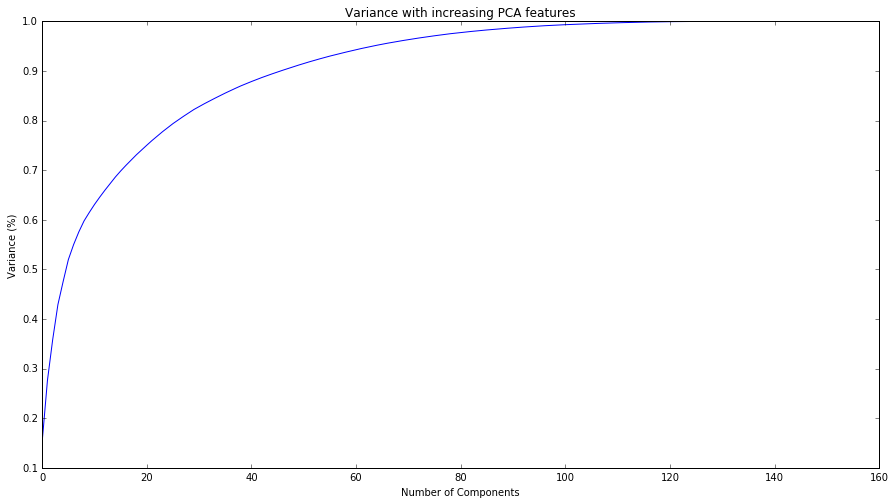

Best n_components is 95


In [127]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
## Re-sacle data between 0,1 for PCA
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(complete_features_dropna)

#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)

#Plotting the Cumulative Summation of the Explained Variance
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Variance with increasing PCA features')
plt.show()
n_components = list(np.cumsum(pca.explained_variance_ratio_)).index(np.cumsum(pca.explained_variance_ratio_)[(np.cumsum(pca.explained_variance_ratio_) >= 0.99)][0])
print("Best n_components is "+ str(n_components))


### Decision Tree 4 
We use the PCA method to transform our data and apply it to the Decision Tree Classifier

In [126]:
X_train, X_test, y_train, y_test = train_test_split(complete_features_dropna,complete_targets_OH_dropna)
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')


pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

cls = fit_model(X_train_pca, y_train)
print("Parameter 'max_depth' is {} for the optimal model.".format(cls.get_params()['max_depth']))
cls.get_params()
cls = DecisionTreeClassifier(max_depth=cls.get_params()['max_depth'])
cls.fit(X_train, y_train)
Y_pred = cls.predict(X_test)

print("Accuracy score for the optimal model is {}.".format(accuracy_score(y_test,Y_pred))) 

models_dict.update({'DT4':accuracy_score(y_test,Y_pred)})


Parameter 'max_depth' is 17 for the optimal model.
Accuracy score for the optimal model is 0.4639927073837739.


We see that the Model has performed slightly better than previous models at 46%, however this could be within range of error.

Finally, before delving into deep learning, we try to use an ensemble method of Random Forests to whether overfitting is our main bottleneck

### Random Forest Classifier 1
Simply, Random forests or are an ensemble learning method for classification that work by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes.



In [128]:

classifier = RandomForestClassifier(max_depth=cls.get_params()['max_depth'])
classifier.fit(X_train_pca,y_train)
Y_pred = classifier.predict(X_test_pca)
print("Accuracy score for the optimal model is {}.".format(accuracy_score(y_test,Y_pred))) 

models_dict.update({'RF1':accuracy_score(y_test,Y_pred)})

Accuracy score for the optimal model is 0.25979945305378305.


We see that for the random forests classifier under PCA features, performance is in-fact worse than the random guess. 

## Deep Neural Networks

In order to increase model accuracy and predictive power, we employed the use of Artificial Neural Networks (ANNs) to model our match data. Neural Networks, as their name suggest are the computational approach to machine learning that is loosely influenced by the mechanisms in the vertebrate brains.  Neurons are connected at nodes, with the input transformed by the node into an output, similar to biological axons. 

A node/ perceptron takes a set of input data, applies an intrinsic set of weights to produce a linear combination, and the resultant combination is operated by an activation function which produces a singular output. Multiple nodes in a single layer produce multiple outputs (through operations with different parameters), these outputs will be the inputs of the next layer.

The general formula for a perceptron is:

$${\displaystyle f(x)  = K(\Sigma_{i} \omega_{i}x_{i})}$$

where $\omega_i$ is the parameter or model weight of the feature $x_i$. $K$ is the activation function. Typically used activation functions are *ReLU:* $${\displaystyle f(x)=x^{+}=\max(0,x)}$$*hyperbolic tangent* $$tanh(x)$$ or *softmax function* $${\displaystyle \sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}}$$

A network
consists of several layers of these neurons, where connections go from one layer to
the other. The first layer is the input layer, the last layer is the output, and all
the layers in between are hidden layers. The image below shows a basic visual of this. 
<img src="img/ANN.png" alt="ANN_0" width="600"/>

The output layer will take all the inputs from the model and produce a final output of target probabilities. This is achieved thorugh a special activation function known as the *sigmoid function*:
$${\displaystyle S(x)={\frac {1}{1+e^{-x}}}={\frac {e^{x}}{e^{x}+1}}.}$$

The 'learning' part is done through two mechanisms, the feedforward described above and backpropagation. Backpropagation is when the weights of the network are updated by calculation of a partial differential of the error function (a function of predictions vs actual targets). Backpropagation occurs at every epoch of the algorithm, and the next epoch uses the newly updated weights.[10]


In [130]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

Using TensorFlow backend.


Our first Neural Network architecture is detailed below. We use dropout layers between the hidden layers. These randomly inhibit nodes to reduce overfitting. 
<img src="img/ANN_1.png" alt="ANN" width="600"/>

### Deep Neural Network 1

In [138]:
X_train, X_test, y_train, y_test = train_test_split(complete_features_dropna,complete_targets_OH_dropna)

X_train, X_test, y_train, y_test     = train_test_split(complete_features_fillna,complete_targets_OH_fillna, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val     = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Building the model
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_1.add(Dropout(.3))
model_1.add(Dense(32, activation='tanh'))
model_1.add(Dropout(.2))
model_1.add(Dense(16, activation='tanh'))
model_1.add(Dropout(.2))
model_1.add(Dense(y_train.shape[1], activation='softmax'))

# Com_3piling the model
model_1.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
hist=model_1.fit(X_train, y_train, epochs=500, batch_size=15, verbose=0, validation_data=(X_val, y_val))
score = model_1.evaluate(X_test, y_test, verbose=0)


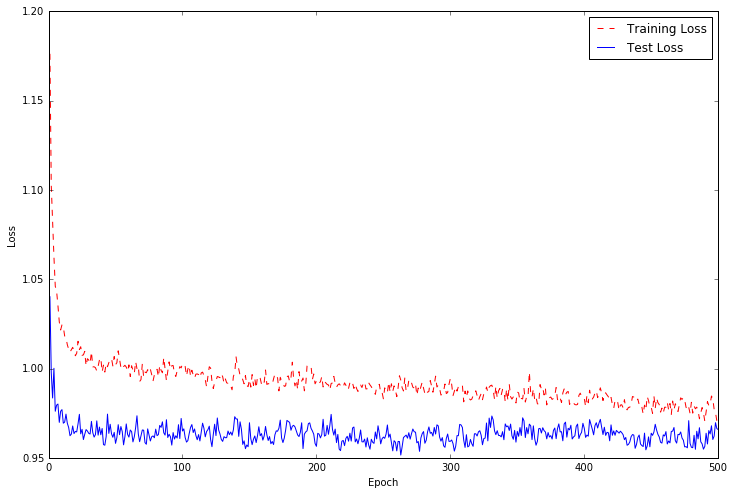

In [140]:
# Get training and test loss histories
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

What we see is that the validation loss/ accuracy converges to stability after around 15 epochs, whilst the training loss looks to still be reducing at 500. It is likely that we will begin to see overfitting after this point. The final accuracy of the model is around 55%, which is significantly higher than both the random guess and the Decision Tree models.

In [143]:
print("Accuracy of the model is : ",score[1])
models_dict.update({'DNN_1':score[1]})

Accuracy of the model is :  0.5493775937072469


### Deep Neural Network 2 & 3
We followed the same pattern as with the Decision Tree, we tried to model our data after feature selection, We also use the zero filled NAN data from this point to further increase the total number of datapoints.  this is shown below: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 64)                1344      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 51        
Total para

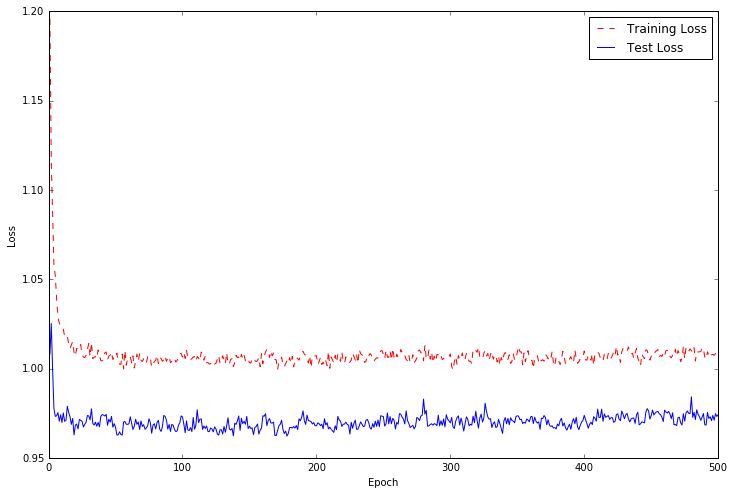

Accuracy:  0.5510373447445913


In [146]:
X = complete_features_fillna  #independent columns
y = complete_targets_fillna #target column i.e price range
#apply SelectKBest class to extract top 10 best features

bestfeatures = SelectKBest(score_func=mutual_info_classif, k="all")
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

new_features_list = featureScores.nlargest(20,'Score')['Specs'].values
new_features = complete_features_fillna[new_features_list]

X_train, X_test, y_train, y_test     = train_test_split(new_features,complete_targets_OH_fillna, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val     = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Building the model
model_2 = Sequential()
model_2.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_2.add(Dropout(.5))
model_2.add(Dense(32, activation='tanh'))
model_2.add(Dropout(.2))
model_2.add(Dense(16, activation='tanh'))
model_2.add(Dropout(.2))
model_2.add(Dense(y_train.shape[1], activation='softmax'))

# Com_3piling the model
model_2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_2.summary()

hist=model_2.fit(X_train, y_train, epochs=500, batch_size=15, verbose=0, validation_data=(X_val, y_val))
score = model_2.evaluate(X_test, y_test, verbose=0)
# Get training and test loss histories
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();



print("Accuracy: ", score[1])
models_dict.update({'DNN_2':score[1]})





We see that accuracy is also around 55%, so no major accuracy increase from above. Next is PCA:

Best n_components is 83
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                5376      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_27 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 3)              

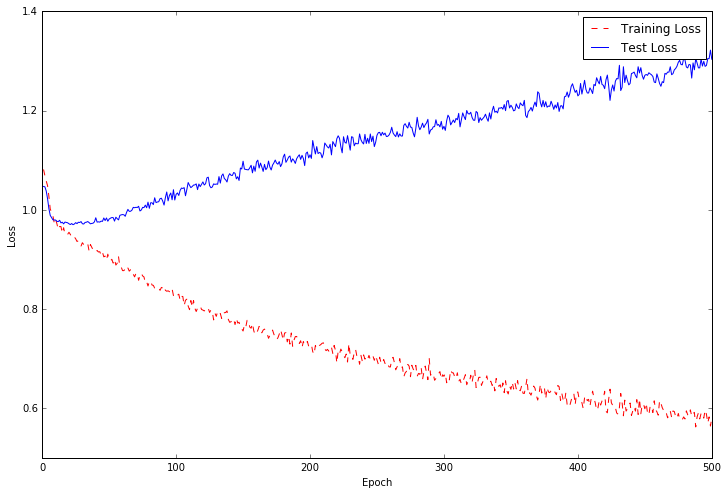

Accuracy:  0.4834663630075574


In [147]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(complete_features_dropna)
#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)


n_components = list(np.cumsum(pca.explained_variance_ratio_)).index(np.cumsum(pca.explained_variance_ratio_)[(np.cumsum(pca.explained_variance_ratio_) >= 0.98)][0])
print("Best n_components is "+ str(n_components))
X_train, X_test, y_train, y_test     = train_test_split(complete_features_dropna,complete_targets_OH_dropna, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val     = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)


# Building the model
model_3 = Sequential()
model_3.add(Dense(64, activation='sigmoid', input_shape=(X_train_pca.shape[1],)))
model_3.add(Dropout(.4))
model_3.add(Dense(32, activation='sigmoid'))
model_3.add(Dropout(.2))
model_3.add(Dense(16, activation='sigmoid'))
model_3.add(Dropout(.2))
model_3.add(Dense(y_train.shape[1], activation='softmax'))

# Com_3piling the model
model_3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()

hist = model_3.fit(X_train_pca, y_train, epochs=500, batch_size=15, verbose=0, validation_data=(X_val_pca, y_val),shuffle=1)
score = model_3.evaluate(X_test_pca, y_test, verbose=0)
print("Accuracy: ", score[1])

# Get training and test loss histories
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();



print("Accuracy: ", score[1])
models_dict.update({'DNN_3':score[1]})


We see that with the PCA regime, clear overfitting occurs early on -- if we re-fit our model with the number of epochs being where the two Losses diverge, we can see that the final accruacy is 54%, similar to previous results.

In [160]:
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']
divergence= np.zeros(len(test_loss))
for i in range(len(test_loss)):
    divergence[i] = (test_loss[i]<training_loss[i])
ind = [i for i, x in enumerate(divergence) if x][-1]
n_epochs = epoch_count[ind]


# Building the model
model_3 = Sequential()
model_3.add(Dense(64, activation='sigmoid', input_shape=(X_train_pca.shape[1],)))
model_3.add(Dropout(.4))
model_3.add(Dense(32, activation='sigmoid'))
model_3.add(Dropout(.2))
model_3.add(Dense(16, activation='sigmoid'))
model_3.add(Dropout(.2))
model_3.add(Dense(y_train.shape[1], activation='softmax'))

# Com_3piling the model
model_3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()

hist = model_3.fit(X_train_pca, y_train, epochs=n_epochs, batch_size=15, verbose=0, validation_data=(X_val_pca, y_val),shuffle=1)
score = model_3.evaluate(X_test_pca, y_test, verbose=0)
print("Accuracy: ", score[1])
models_dict.update({'DNN_3':score[1]})


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                5376      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_30 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 51        
Total para

# 5 Results & Conclusion

Below we have plotted the accuracy scores of all the different models we have chosen and refined. What we are able to see is that the accuracies for the models respectively fall within some error range from the following:

* Initial DNN = 0.54937759 
* DNN with MI Feature selection = 0.55103734
* DNN with PCA feature selection 0.53705815 
* Initial Decision Tree = 0.41112124 
* Decision Tree with MI feature selection(25 features) = 0.4247949
* Decision Tree with MI  feature selection (50 features) = 0.41567912
* Decision Tree with PCA feature selection =  0.46399271 
* Random Forests Classifier = 0.25979945
* Random Guessing  = 0.301732  

Clearly, Neural networks produced the best predictive power for predicting match outcomes, and Decision Trees come second. Both performed better than random guessing, which is a positive result. 

It seems as there was not enough evidence to show that any of the feature selection tools had any significant effect to the final result. This may be because of the significance of the weights for the smaller features, these insignificant features made little difference to the final models, and therefore feature selection would not modify much. 

Neural Networks produced the best results, this is because of their robustness with small datasets compared to number of features. Decisions trees require much more samples in order to reduce overfitting.

Overall, because we outperformed our benchmark metric and peformed similarily to the previously mentioned studies, we are justified to call this venture a success. Clearly there is also room for improvement which will only serve to increase predictive ability. 




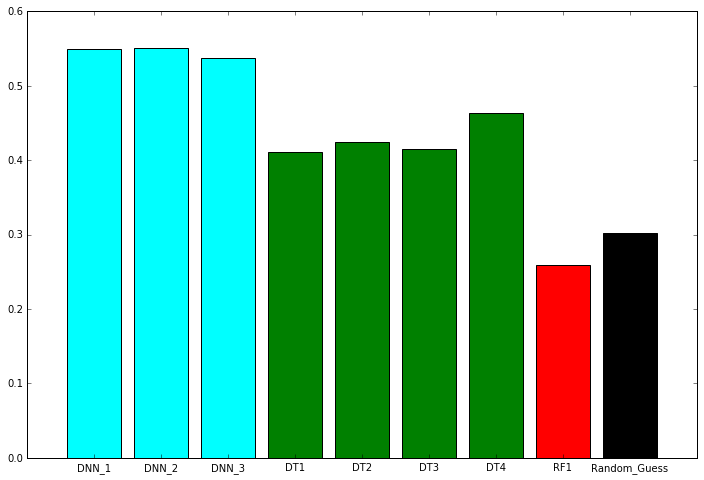

In [193]:
import matplotlib.pyplot as plt

D = models_dict
dk = copy.deepcopy(list(D.keys()))
dk.sort()
sv = np.zeros(len(dk))
for i,j in enumerate(dk):
    sv[i] = D[j]
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(range(len(D)),sv, align='center', color=['cyan', 'cyan', 'cyan', 'green', 'green', 'green', 'green','red','black'])
plt.xticks(range(len(D)), list(dk))

plt.show()

# 6 Reflection & Discussion

Looking back at the work done, there are a number of points to take note when discussing obstacles and shortcomings:

- For a project such as this, much time is required to research the relevant features - - there is an endless suply of potential metrics that can be shown to influence football matches. This is a whole project by itself. 
- In relevent terms, data is scarce, the game of football is everywhere but it changes a lot over time, startegies and factors that are important in a certain generation or a certain region may not be nearly as important in another - these changes are very unpredictable and will serve to reduce the reliability to large samples. 
- There are countless different models and algos that can be suitable in a project like this, we must bare in mind that this is only a snippet of what is possible for this problem.

What I found interesting: 
- Building a database was something was interesting, clearly having the flexibility to query results and create feature list from commands is very powerful. 

What was difficult:
- Difficulty was reflecting ML theory to this dataset, deep learning is popular and is thought of as the ubiquitous algorithm set to use for many problems and hence why it was chosen here, however it does beg the question of whether we have not found something better to suit our dataset.

Things to Improve:
- Look at changing the lookback window of historic data and trying the models again
- Removing a particular feature set, such as previous season data to see if predictive power increases
- Try multiple other ANN architectures
- Try different models
- There are many other interesting features that were not included because of lack of data, things like possession stats, statdium attendence, games from outside prem league, player ratings, injuries and countless more. These stats will be interesting to use.
- Look at changing target data set from outcome to exact results, one-hot-encoding the final result may lead to a very long list of potential targets, this may however become non-sensicle.




# References
[1] http://publications.lib.chalmers.se/records/fulltext/250411/250411.pdf

[2] https://www.imperial.ac.uk/media/imperial-college/faculty-of-engineering/computing/public/1718-ug-projects/Corentin-Herbinet-Using-Machine-Learning-techniques-to-predict-the-outcome-of-profressional-football-matches.pdf

[3] http://www.football-data.co.uk/englandm.php

[4] https://en.wikipedia.org/wiki/Curse_of_dimensionality

[5] https://en.wikipedia.org/wiki/Decision_tree_learning

[6] https://thuijskens.github.io/2017/10/07/feature-selection/

[7] http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/

[8] http://setosa.io/ev/principal-component-analysis/

[9] https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

[10] http://neuralnetworksanddeeplearning.com/chap2.html
